# Прогнозирование оттока клиентов в компании связи.


**Условие задачи**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

contract.csv — информация о договоре;
personal.csv — персональные данные клиента;
internet.csv — информация об интернет-услугах;
phone.csv — информация об услугах телефонии.
Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Загрузка данных и первоначальный анализ.

Загрузим необходимые для работы библиотеки.

In [ ]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import catboost as cb
import lightgbm as lgb
import phik

Загрузим необходимые для анализа данные.

In [ ]:
try:
  phone = pd.read_csv('/datasets/final_provider/phone.csv')
  contract = pd.read_csv('/datasets/final_provider/contract.csv')
  personal = pd.read_csv('/datasets/final_provider/personal.csv')
  internet = pd.read_csv('/datasets/final_provider/internet.csv')

except FileNotFoundError:
  phone = pd.read_csv('/content/phone.csv')
  contract = pd.read_csv('/content/contract.csv')
  personal = pd.read_csv('/content/personal.csv')
  internet = pd.read_csv('/content/internet.csv')

Изучим основые характеристики каждого датасета. 

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone.info()
print()
phone['MultipleLines'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB



No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Файл содержит 6361 строку и 2 столбца. Пропусков нет, распределение данных в столбце 'MultipleLines' примерно равномерное.

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В данном датасете нужно провести дополнительную работу:
- перевести несколько столбцов в новый формат;
- провести расчет сколько месяцев клиента пользовался услугами компании;
- создать столбец с целевым признаком для дальнейшего обучения.

Переведем столбец TotalCharges в формат float64

In [ ]:
contract['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [ ]:
contract['TotalCharges'].unique().min()

' '

Посмотрим в каких строках есть пропуски.

In [ ]:
contract.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Дата начала действия договора у всем клиентов с пропуском в TotalCharges стоит 2020-02-01. Возможно, расчет итоговой оплаты еще не проводилось. Заполним пропуски данными из MonthlyCharges.

In [ ]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract['MonthlyCharges']
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

Создадим целевой признак.

In [ ]:
# Если клиент отказался от услуг компании, то укажем 1, а если нет, то 0. 
#Т.е. если в столбце EndDate стоит дата, то ставим 1, если No, то заполняем 0.

contract['no_client'] = 1
contract.loc[contract['EndDate'] == 'No', 'no_client'] = 0

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,no_client
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Приведем столбцы BeginDate и EndDate в единый формат даты, в столбце EndDate есть показания "No"(договор не завершен, значит клиент не ушел). Заменим их на дату актуальности базы данных. 

In [ ]:
# Заполняем данные No на дату актуальнусти базы данных.
contract['EndDate']= contract['EndDate'].replace('No', '2020-02-01')

# Переводим столбцы в формат даты.
contract['BeginDate']= pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate']= pd.to_datetime(contract['EndDate'], format='%Y-%m-%dT%H:%M:%S',errors='coerce')

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,no_client
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


Создадим столбец TotalDays с расчетом срока договора клиента в месяцах.

In [ ]:
contract['TotalDays'] = (contract['EndDate'] - contract['BeginDate']).dt.days
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   no_client         7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,no_client,TotalDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


Посмотрим соотношение ушедшик клиентов к существующим. 

In [ ]:
contract['no_client'].value_counts()

0    5174
1    1869
Name: no_client, dtype: int64

Ушедших клиентов почти в 3 раза меньше, чем оставшихся. Это может повлиять на качество обучение. Учтем этот дисбаланс классов при подготовке данных.

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   no_client         7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


In [ ]:
contract.describe()

,MonthlyCharges,TotalCharges,no_client,TotalDays
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.265370,985.996166
std,30.090047,2266.730170,0.441561,747.587844
min,18.250000,18.800000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000
50%,70.350000,1394.550000,0.000000,883.000000
75%,89.850000,3786.600000,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


Итоговый датасет contract содержит 7043 строки и 10 столбцов. Пропусков нет.

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Файл содержит 5517 строк и 8 столбцов. Пропусков нет.

## Выводы.

- Как мы видим всего в данных у нас 7043 клиента, договоров на интернет заключено 5517, а на телефонную связь 6361;
- Пропусков в данных нет. Стоит проверить данные на дубликаты, а также на аномалии;
- В датасете contract провели расчет количества месяцев действия договора, а таже добавили целевой признак для дальнейшего обучения.

# Анализ данных и визуализация

Проверим наличие дубликатов в каждом датасете.

In [ ]:
print(phone.duplicated().sum()),
print(contract.duplicated().sum()),
print(personal.duplicated().sum()),
print(internet.duplicated().sum())

0
0
0
0


Дубликатов нет.

Для дальнейшего анализа объеденим все датафреймы по customerID.

In [ ]:
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   no_client         7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  MultipleLines     6361 n

После объединения датафреймов появились пропуски в данных, если есть пропуски, то значит, что клиент данными услугами не пользуется. Заполним пропуски значением No.

In [ ]:
for i in ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[i] = df[i].fillna('No')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,no_client,TotalDays,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,No,Fiber optic,No,No,No,No,No,No


## Визуализация данных

Для удобства работы с данными создадим список с нужными нам признаками.

In [ ]:
categorial_columns = ['Type','PaymentMethod','gender','SeniorCitizen','InternetService']

Посмотрим распределения категориальных признаков.

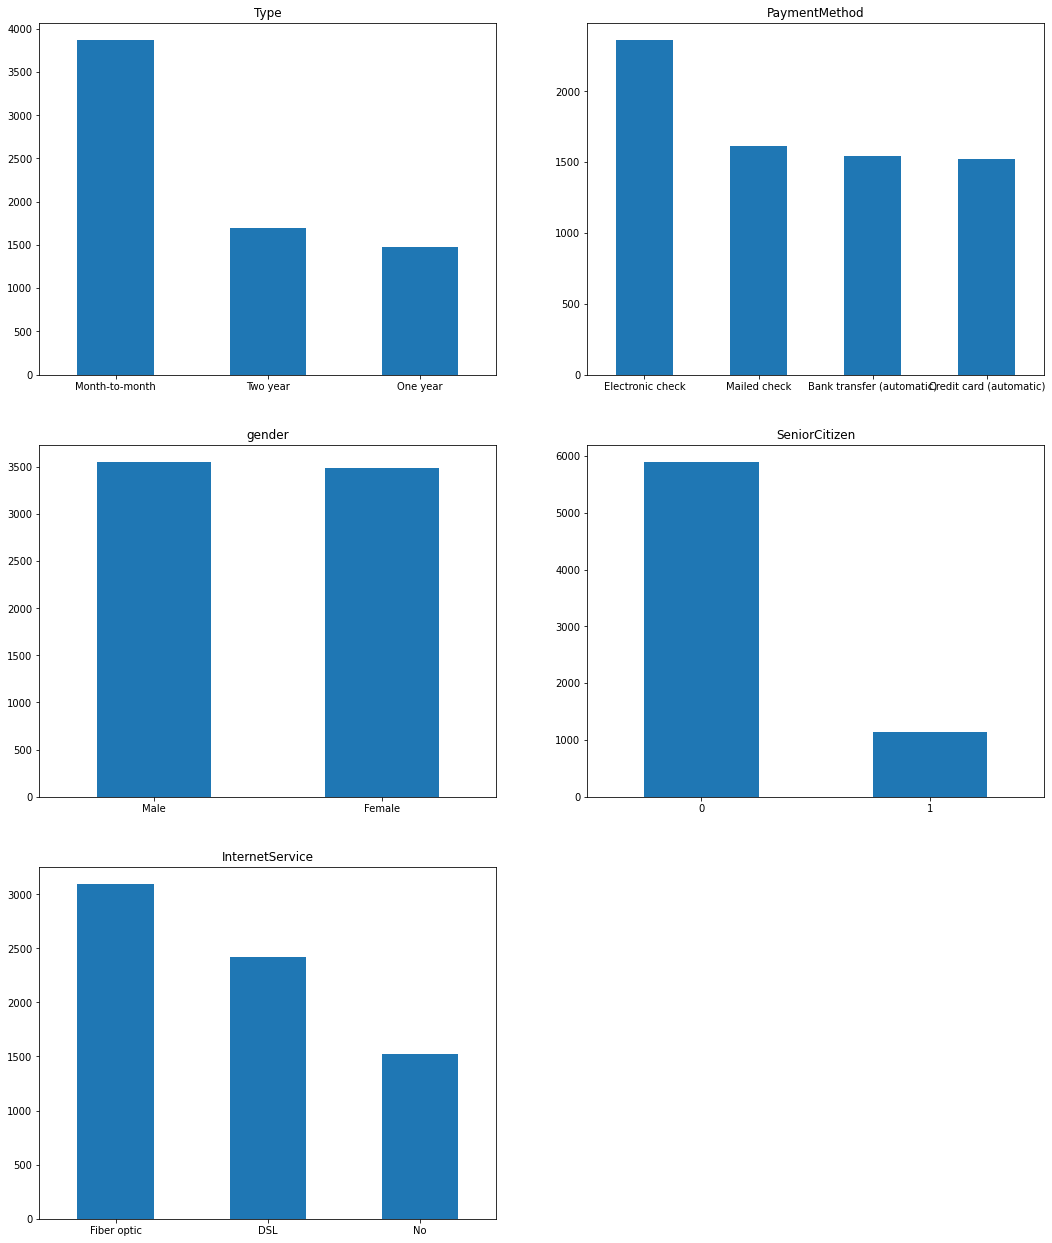

In [ ]:
plt.figure(figsize=(18, 22))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(3, 2, idx + 1)
    
    df[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0)
        
plt.show()

*   Большинство клиентов оплачивают услуги раз в месяц;
*   Лидером в методах оплаты является электронный чек, остальные виды оплаты распределены равномерно;
*   Мужчин и женщин примерно одинаковое количество;
*   В столбце SeniorCitizen - пожилых клиентов почти в 6 раз меньше, чем другой категории;
*   В столбце InternetService - клиентов с подключением интернета через оптоволокно больше всего, через телефонную линию меньше, но не значительно. 

Посмотрим как распределяется приток клиентов. Растет ли вообще количество клиентов. 

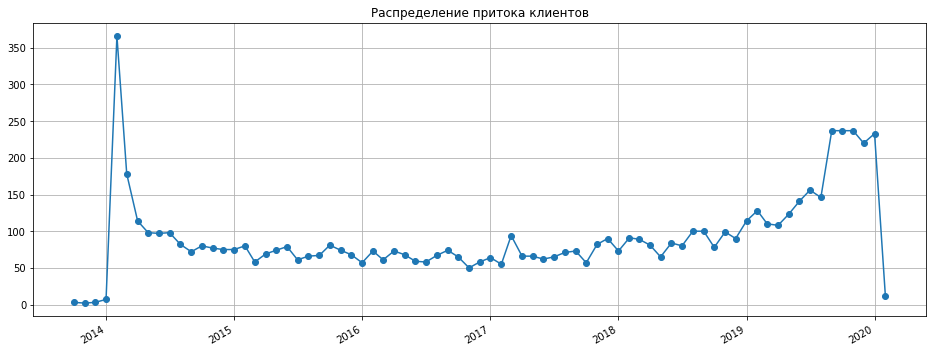

In [ ]:
df['BeginDate'].value_counts().plot(style='o-', grid=True,figsize=(16, 6))
plt.title("Распределение притока клиентов")
plt.show()

Есть существенный пик роста клиентов в начале 2014 года, возможно это связано с какой-то маркетиноговой активности. Далее приток клиентов примерно на одном уровне(50-80 клиентов в месяц). С середины 2018 года до 2020 года начинается постепенный рост притока клиентов.

# Анализ распределения величин.

Проведем сравнение поведения существующих клиентов и ушедших по всем услугами, а также по платежам. В том числе посмотрим их долю среди пользователей телефонной связи и интернета.

In [ ]:
# создадим функцию 

def table_for_group(col_group):
    table1 = df.groupby(col_group, as_index=False)['no_client'].sum()
    table2 = df.groupby(col_group, as_index=False)['customerID'].count()
    merge = table1.merge(table2, on=col_group)
    merge.rename(columns = {'customerID':'all'}, inplace = True)
    merge['client'] = merge['all'] - merge['no_client']
    merge = merge.drop('all', axis=1)
      
    return merge

,Type,no_client,client
0,Month-to-month,1655,2220
1,One year,166,1307
2,Two year,48,1647


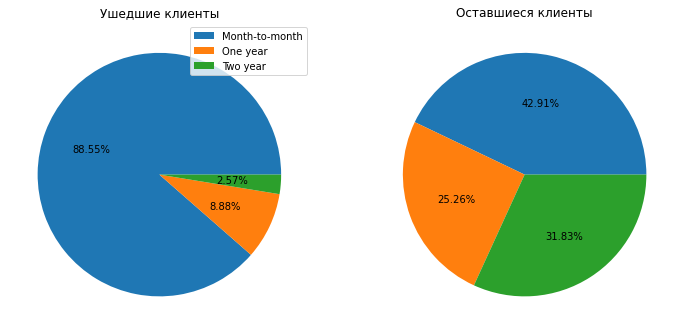

,PaperlessBilling,no_client,client
0,No,469,2403
1,Yes,1400,2771


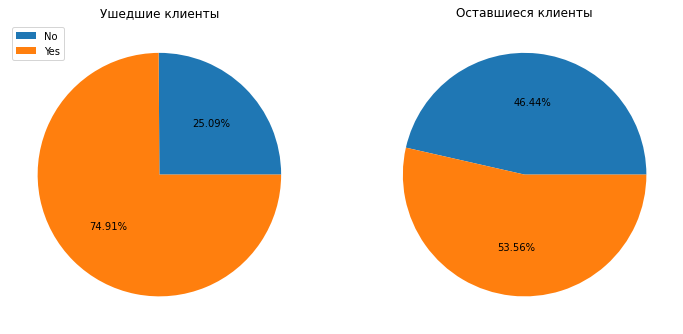

,PaymentMethod,no_client,client
0,Bank transfer (automatic),258,1286
1,Credit card (automatic),232,1290
2,Electronic check,1071,1294
3,Mailed check,308,1304


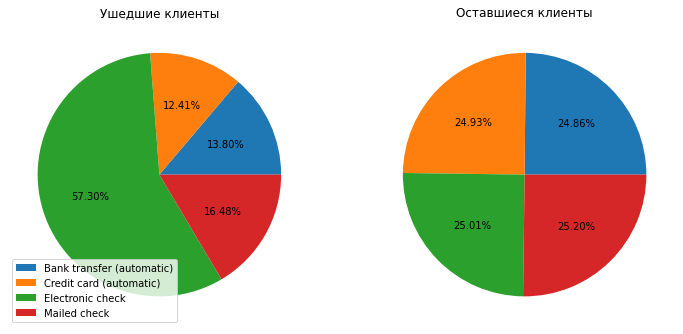

,gender,no_client,client
0,Female,939,2549
1,Male,930,2625


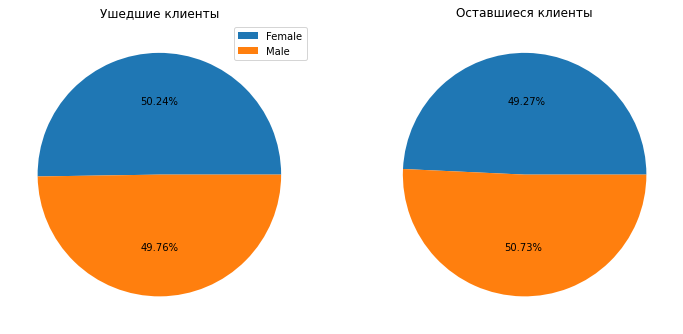

,SeniorCitizen,no_client,client
0,0,1393,4508
1,1,476,666


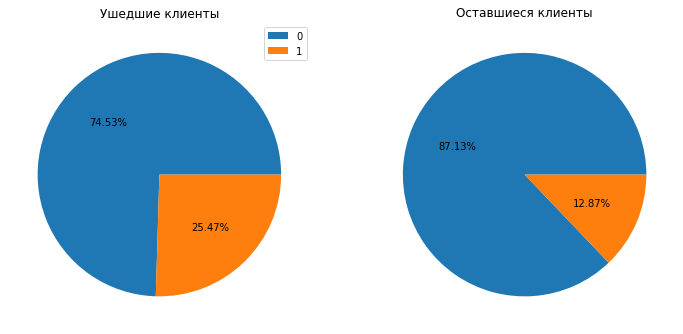

,Partner,no_client,client
0,No,1200,2441
1,Yes,669,2733


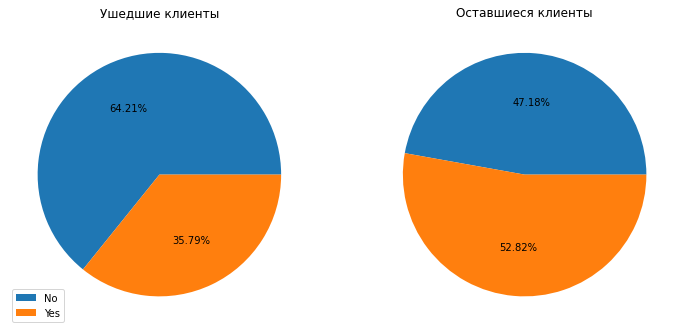

,Dependents,no_client,client
0,No,1543,3390
1,Yes,326,1784


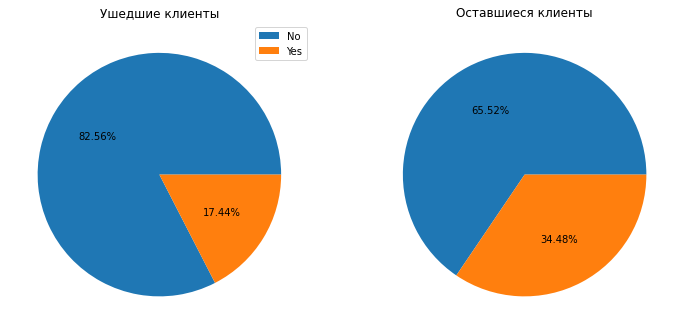

,InternetService,no_client,client
0,DSL,459,1962
1,Fiber optic,1297,1799
2,No,113,1413


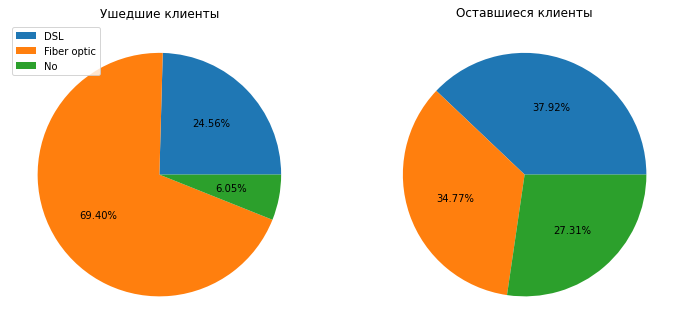

,OnlineSecurity,no_client,client
0,No,1574,3450
1,Yes,295,1724


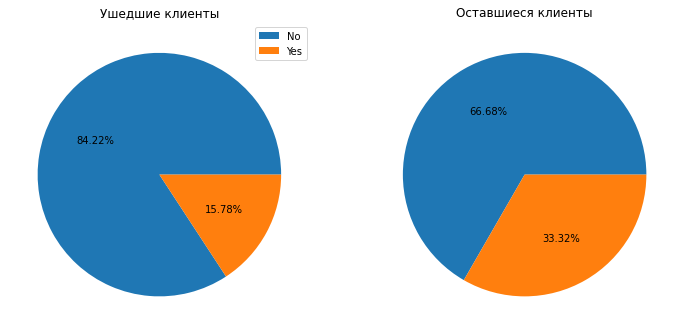

,OnlineBackup,no_client,client
0,No,1346,3268
1,Yes,523,1906


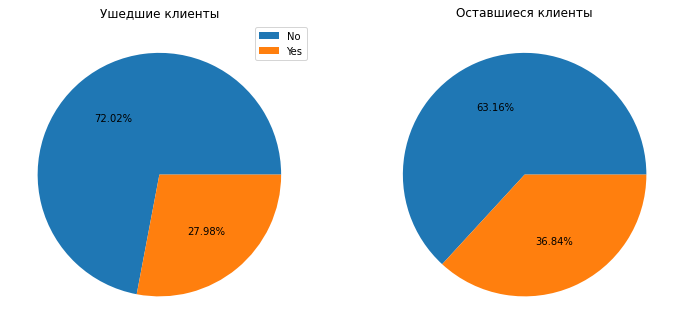

,DeviceProtection,no_client,client
0,No,1324,3297
1,Yes,545,1877


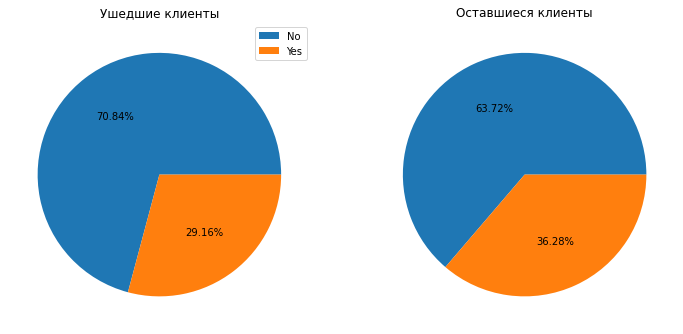

,TechSupport,no_client,client
0,No,1559,3440
1,Yes,310,1734


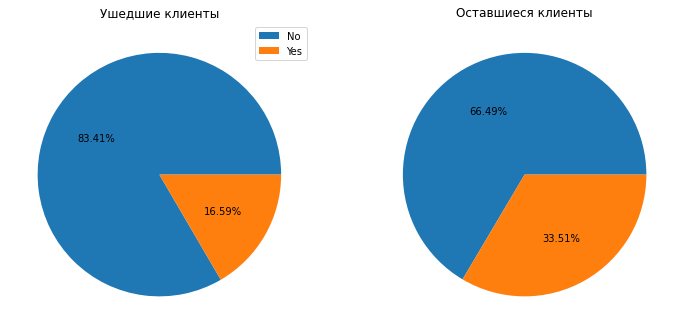

,StreamingTV,no_client,client
0,No,1055,3281
1,Yes,814,1893


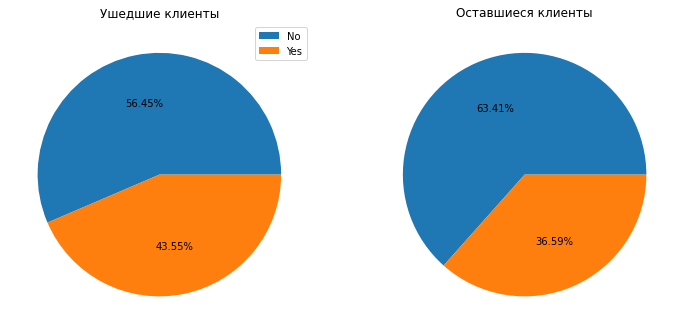

,StreamingMovies,no_client,client
0,No,1051,3260
1,Yes,818,1914


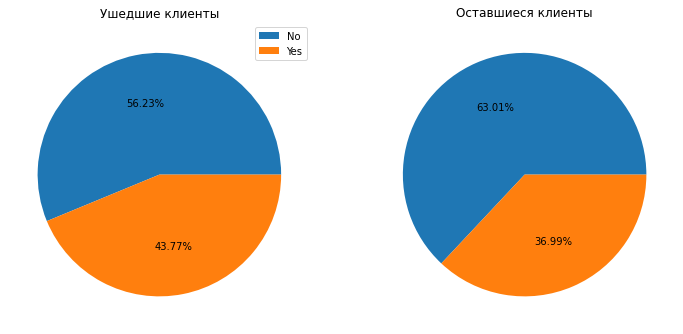

,MultipleLines,no_client,client
0,No,1019,3053
1,Yes,850,2121


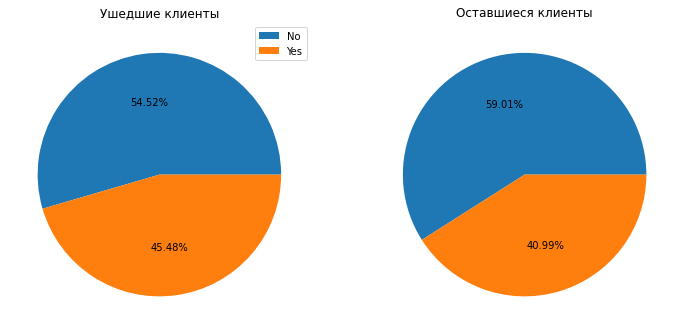

In [ ]:
# вызовем функцию для всех категориальных признаков

categorials_columns = ['Type','PaperlessBilling','PaymentMethod','gender','SeniorCitizen','Partner','Dependents','InternetService', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in categorials_columns:
    table = table_for_group(col)
    display(table)
    print()
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.pie(table['no_client'], autopct='%1.2f%%')
    plt.legend(labels=table[col], loc='best')
    plt.title('Ушедшие клиенты')   
    
    plt.subplot(1, 2, 2)
    plt.pie(table['client'], autopct='%1.2f%%')
    plt.title('Оставшиеся клиенты')
    plt.show()

**Выводы:**

* Самый популярный способ оплаты - помесячный. Однако, у ушедших клиенов доля помесячной оплаты значительно выше (88,5%), чем у существующих клиентов (42%).
* Более популярны электронные счета. Но у существующих клиентов разница с бумажными счетами незначительная, а у ушедших клиентов доля электронных счетов значительная (75%).
* У ушедших клиентов оплата чаще всего проводилась электронным чеком (57%). А вот у существующих клиентов все виды оплаты распределены равномерно.
* Среди клиентов и ушедших пол распределен совершенно равномерно.
* Пожилых клиентов в обеих группах значительно меньше, но среди ушедших клиентов их немного больше.
* Среди ушедших клиентов одиноких людей больше.
* Клиентов без иждевенцев больше в обеих группах.
* У ушедших клиентов оптоволокно самое популярное, возможно клиенты были не довольны стоимостью услуги, а возможно качеством связи. Стоит порекомендовать маркетологам провести опрос.
* Дополнительные услуги слабо влияют на отказы.

Посмотрим распределение количественных значений среди ушедших и существующих клиентов.

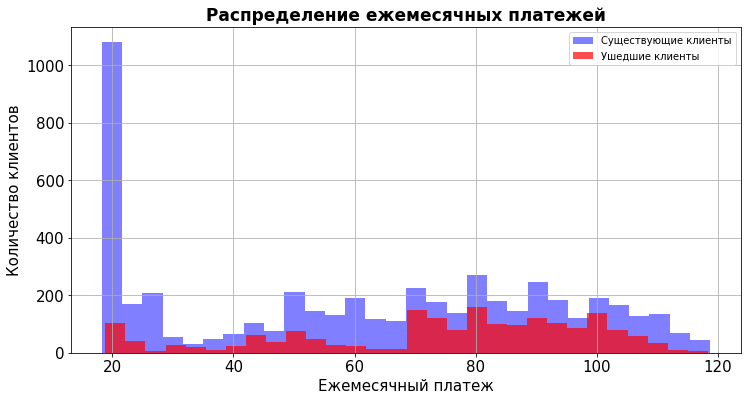

In [ ]:
# Проверим распределение ежемесячных платежей по ушедшим клиентам и оставшимся.

ax = df[df['no_client']==0].plot(kind='hist', y='MonthlyCharges', bins=30, 
                              linewidth=1, alpha=0.5, label='Сущеcтвующие клиенты', color='b')
df[df['no_client']==1].plot(kind='hist', y='MonthlyCharges', bins=30,linewidth=1, alpha=0.7, 
                         label='Ушедшие клиенты', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='r')
ax.set_ylabel('Количество клиентов', fontsize=15)
ax.set_xlabel('Ежемесячный платеж', fontsize=15)
ax.set_title('Распределение ежемесячных платежей', fontsize=17, fontweight='bold')
plt.show()

По графику четко видно, что большинство всех клиентов платят 20 едениц(не понятно какая валюта). 
Среди ушедших клиентов большинство находится в интервале от 70 до 100 ед. Возможно, стоимость для этих людей существенных фактор.

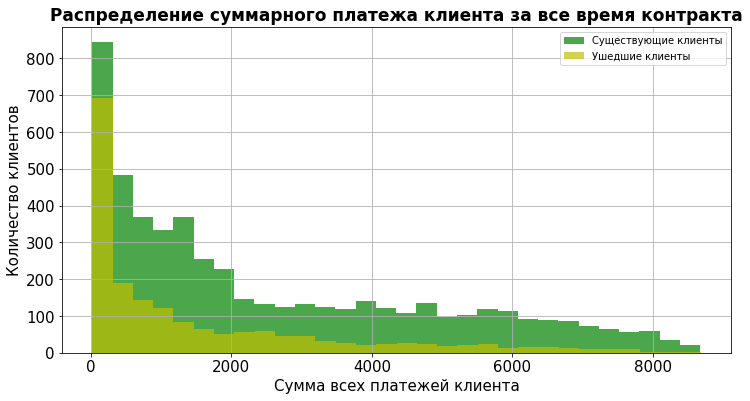

In [ ]:
# Проверим распределение суммарного платежа за все время для каждого клиента по ушедшим и существующим клиентам. 

ax = df[df['no_client']==0].plot(kind='hist', y='TotalCharges', bins=30, 
                              linewidth=1, alpha=0.7, label='Сущеcтвующие клиенты', color='g')
df[df['no_client']==1].plot(kind='hist', y='TotalCharges', bins=30,linewidth=1, alpha=0.7, 
                         label='Ушедшие клиенты', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='y')
ax.set_ylabel('Количество клиентов', fontsize=15)
ax.set_xlabel('Сумма всех платежей клиента', fontsize=15)
ax.set_title('Распределение суммарного платежа клиента за все время контракта', fontsize=17, fontweight='bold')
plt.show()

Распределение по ушедшим и существующим клиентам практически одинаковое, отличается только количество пользователей. Мы видим, что основная масса клиентов имеет итоговую сумму не превышающую 1000 ед. Это скорее всего связано с временными ограничениями базы. Возможно, компания молодая и пока не накопила большой пул "старичков" или же клиенты после определенного срока пользования услугами уходят. Этот вопрос стоит обсудить с маркетологами.

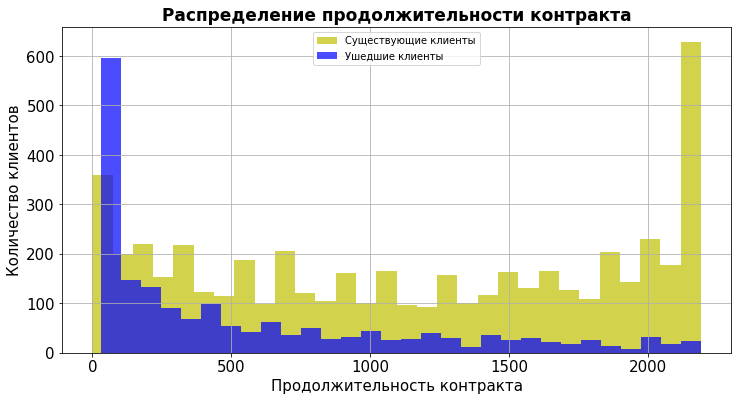

In [ ]:
# Проверим распределение продолжительности контракта для ушедших и существующих клиентов. 

ax = df[df['no_client']==0].plot(kind='hist', y='TotalDays', bins=30, 
                              linewidth=1, alpha=0.7, label='Сущеcтвующие клиенты', color='y')
df[df['no_client']==1].plot(kind='hist', y='TotalDays', bins=30,linewidth=1, alpha=0.7, 
                         label='Ушедшие клиенты', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='b')
ax.set_ylabel('Количество клиентов', fontsize=15)
ax.set_xlabel('Продолжительность контракта', fontsize=15)
ax.set_title('Распределение продолжительности контракта', fontsize=17, fontweight='bold')
plt.show()

По графику мы видим, что в основном клиенты уходят в первые 5-7 месяцев действия договора. Далее распределение оттока клиентов примерно равномерное.

**Выводы:**

Данные были проанализированы и визуализированы. Сделали несколько выводов и предположений.

## Исследование корреляции признаков.

Для наилучшего понимания наших признаков и их взаимосвязи между собой исследуем корреляцию признаков.

Сначала проверим корреляцию числовых признаков. Проведем анализ мультиколлинеарности с помощью матрицы признаков.

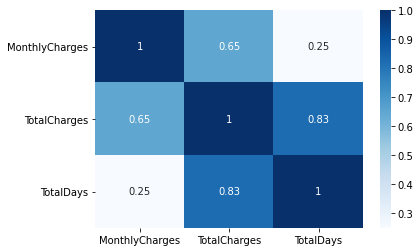

In [ ]:
plt.figure(figsize=(6,4))
correlations = df[['MonthlyCharges', 'TotalCharges', 'TotalDays']].corr()
sns.heatmap(correlations, annot=True, cmap='Blues')
plt.show()

Как мы видим признаки TotalDays и TotalCharges имеют корреляцию. Оно и понятно, чем дольше срок контракта, тем больше будет итоговая сумма. При подготовке признаков к обучению удалим признаак TotalCharges

interval columns not set, guessing: ['SeniorCitizen', 'no_client']


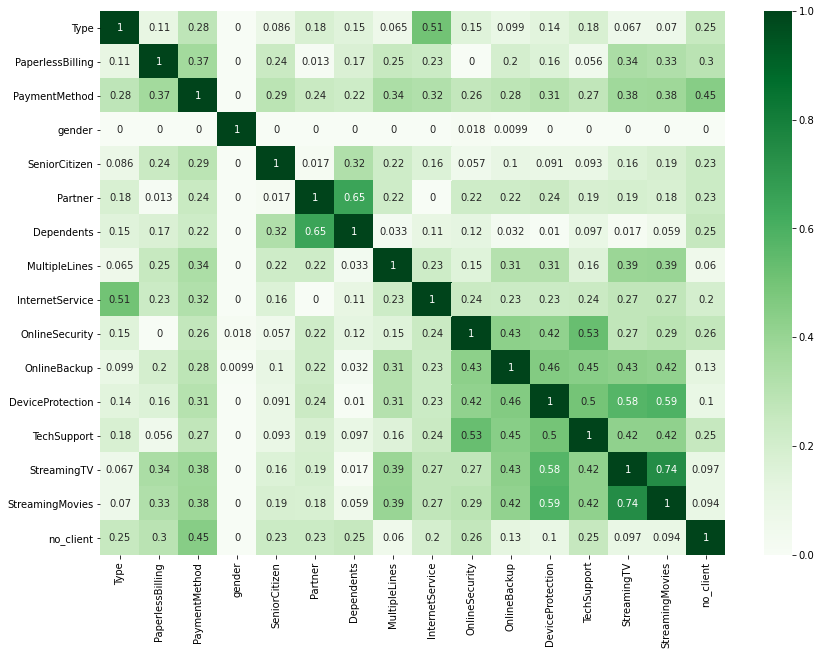

In [ ]:
plt.figure(figsize=(14,10))
phik_cor = df[['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 
               'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 
               'InternetService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'no_client']].phik_matrix()
sns.heatmap(phik_cor, annot=True, cmap='Greens')
plt.show()

In [ ]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
no_client           0
TotalDays           0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

# Подготовка данных к анализу.

Некоторые столбцы (PaperlessBilling, Partner, Dependents OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines) имеют значения NO и YES (бинарные данные). Переведем их в 0 и 1. Чтобы при обучении модель смогла эффективно проанализировать данные.

In [ ]:
# напишем функцию для замени Yes на 1 и  No на 0.

def one_zero(sense):
    if sense == 'Yes':
        return 1
    else:
        return 0

In [ ]:
# создаем список с нужными столбцами.
column = ['PaperlessBilling', 'Partner','Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
          'StreamingTV', 'StreamingMovies','MultipleLines']

for col in column:
  df[col] = df[col].apply(one_zero)

df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,no_client,TotalDays,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,31,...,1,0,0,DSL,0,1,0,0,0,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,1036,...,0,0,0,DSL,1,0,1,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61,...,0,0,0,DSL,1,1,0,0,0,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371,...,0,0,0,DSL,1,0,1,1,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61,...,0,0,0,Fiber optic,0,0,0,0,0,0


Для обучения моделей будем использовать копию нашего датафрейма.

In [ ]:
df_new = df.copy()

Некторые признаки стоит удалить, потому что на мой взгляд они не существенные  или коллерируют друг с другом и только будут мешать моделям обучаться.
Удалим customerID, TotalCharges, gender.
Признаки BeginDate и EndDate тоже удалим, потому что они могут быть причиной утечки данных для моделей.

In [ ]:
df_new = df.drop(['customerID', 'TotalCharges', 'BeginDate','EndDate','gender'], axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   no_client         7043 non-null   int64  
 5   TotalDays         7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int64  
 8   Dependents        7043 non-null   int64  
 9   MultipleLines     7043 non-null   int64  
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   int64  
 12  OnlineBackup      7043 non-null   int64  
 13  DeviceProtection  7043 non-null   int64  
 14  TechSupport       7043 non-null   int64  
 15  StreamingTV       7043 non-null   int64  
 16  StreamingMovies   7043 non-null   int64  


Для обучающей выборке создадим признаки и целевой признак.

In [ ]:
features = df_new.drop('no_client', axis=1) 
target = df_new['no_client']


Создадим тестовую и обучающую выборки.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=171022)

print(features_train.shape, features_test.shape)

(5282, 16) (1761, 16)


Проведем преобразование категориальных признаков в численные техникой прямого кодирования One-Hot Encoding.

In [ ]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), features.select_dtypes(object).columns), remainder='passthrough')

In [ ]:
category_col = ['Type', 'PaymentMethod', 'InternetService']
transformed_train = transformer.fit_transform(features_train)
features_train_ohe = pd.DataFrame(transformed_train, columns=transformer.get_feature_names())

transformed_test = transformer.transform(features_test)
features_test_ohe = pd.DataFrame(transformed_test, columns=transformer.get_feature_names())

In [ ]:
features_test_ohe.head()

,onehotencoder__x0_One year,onehotencoder__x0_Two year,onehotencoder__x1_Credit card (automatic),onehotencoder__x1_Electronic check,onehotencoder__x1_Mailed check,onehotencoder__x2_Fiber optic,onehotencoder__x2_No,PaperlessBilling,MonthlyCharges,TotalDays,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,116.25,2163.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,100.50,1432.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,45.20,1645.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,19.90,31.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,20.05,306.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Масштабируем наши количественные признаки. 

In [ ]:
# создаем список со столбцами с количественными данными.
numeric = ['MonthlyCharges', 'TotalDays']
# трансформируем данные
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])
pd.options.mode.chained_assignment = None;
features_train_ohe.head()

,onehotencoder__x0_One year,onehotencoder__x0_Two year,onehotencoder__x1_Credit card (automatic),onehotencoder__x1_Electronic check,onehotencoder__x1_Mailed check,onehotencoder__x2_Fiber optic,onehotencoder__x2_No,PaperlessBilling,MonthlyCharges,TotalDays,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.722662,-0.982337,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.476261,-0.699566,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.496239,-1.267776,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.143663,0.680945,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.307034,1.209140,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Обучение моделей

Обучать модели будем на тестовой выборке, а качество моделей определять при помощи кросс-валидации. Для оценки качества модели будем использовать roc-auc, на тестовой выборке проверим еще и accuracy.


## Модель Случайного леса.

In [ ]:
model = RandomForestClassifier(random_state=171022)

parametrs = {'max_depth': range (1, 13, 2),
            'n_estimators': range (10, 50, 10),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2)}

# Запускаем обучение
grid_forest = GridSearchCV(model, parametrs, cv=5, scoring='roc_auc')
grid_forest.fit(features_train_ohe, target_train)

# Выводим лучший результат
print(grid_forest.best_params_)
grid_forest.best_score_

{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 40}


0.8588556197076596

In [ ]:
print('Roc_auc для случайного леса:', grid_forest.best_score_)

Roc_auc для случайного леса: 0.8588556197076596


## Модель Catboost

In [ ]:
model = cb.CatBoostClassifier()

parametrs = {'depth': [1, 2, 3],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'l2_leaf_reg': [1, 2, 5]}

grid_cat = GridSearchCV(model, parametrs, scoring='roc_auc', cv=5, n_jobs=-1)
grid_cat.fit(features_train_ohe, target_train, verbose=10)
print(grid_cat.best_params_)
grid_cat.best_score_

0:	learn: 0.6604896	total: 47.1ms	remaining: 47.1s
10:	learn: 0.5093435	total: 54.4ms	remaining: 4.89s
20:	learn: 0.4697337	total: 61.5ms	remaining: 2.87s
30:	learn: 0.4453974	total: 68.2ms	remaining: 2.13s
40:	learn: 0.4349512	total: 74.9ms	remaining: 1.75s
50:	learn: 0.4258613	total: 81.7ms	remaining: 1.52s
60:	learn: 0.4207687	total: 88.6ms	remaining: 1.36s
70:	learn: 0.4155909	total: 95.2ms	remaining: 1.25s
80:	learn: 0.4119247	total: 102ms	remaining: 1.16s
90:	learn: 0.4085932	total: 109ms	remaining: 1.09s
100:	learn: 0.4050577	total: 116ms	remaining: 1.03s
110:	learn: 0.4028933	total: 125ms	remaining: 999ms
120:	learn: 0.4005488	total: 133ms	remaining: 963ms
130:	learn: 0.3990961	total: 140ms	remaining: 926ms
140:	learn: 0.3980011	total: 146ms	remaining: 889ms
150:	learn: 0.3964023	total: 152ms	remaining: 857ms
160:	learn: 0.3956583	total: 159ms	remaining: 829ms
170:	learn: 0.3949885	total: 166ms	remaining: 802ms
180:	learn: 0.3943389	total: 174ms	remaining: 785ms
190:	learn: 0.3

0.9344861877842208

In [ ]:
print('Roc_auc для CatBoost:', grid_cat.best_score_)

Roc_auc для CatBoost: 0.9344861877842208


## Модель Градиентный бустинг LightGBM.

In [ ]:
model = lgb.LGBMClassifier()

parametrs = {'max_depth': range(-1, 10),
             'learning_rate': [0.2, 0.5, 0.7],
             'n_estimators': [200, 500, 600],
             }

grid_lgbm = GridSearchCV(model, parametrs, scoring='roc_auc', cv=5)
grid_lgbm.fit(features_train_ohe, target_train)
print(grid_lgbm.best_params_)
grid_lgbm.best_score_

{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 500}


0.9188628181711842

In [ ]:
print ('Roc_auc для LightGBM', grid_lgbm.best_score_)

Roc_auc для LightGBM 0.9188628181711842


## Выбор наилучшей модели, проверка модели на тестовой выборке.

In [ ]:
print('ROC_AUC случайного леса:', grid_forest.best_score_)
print('ROC_AUC градиентного бустинга Catboost:', grid_cat.best_score_)
print('ROC_AUC градиентного бустинга LGBM:', grid_lgbm.best_score_)

ROC_AUC случайного леса: 0.8588556197076596
ROC_AUC градиентного бустинга Catboost: 0.9344861877842208
ROC_AUC градиентного бустинга LGBM: 0.9188628181711842


Наилучшие результаты на тренировочной выборке показала модель Catboost.

In [ ]:
model = cb.CatBoostClassifier(depth=2, l2_leaf_reg=2, learning_rate=0.3).fit(features_train_ohe, target_train)
predicted = (model.predict_proba(features_test_ohe))[:, 1]
score_roc_auc = roc_auc_score(target_test, predicted)

0:	learn: 0.5668625	total: 1.11ms	remaining: 1.11s
1:	learn: 0.5021569	total: 2.39ms	remaining: 1.19s
2:	learn: 0.4743108	total: 3.42ms	remaining: 1.14s
3:	learn: 0.4527201	total: 4.41ms	remaining: 1.1s
4:	learn: 0.4398439	total: 5.52ms	remaining: 1.1s
5:	learn: 0.4309053	total: 6.52ms	remaining: 1.08s
6:	learn: 0.4249956	total: 7.5ms	remaining: 1.06s
7:	learn: 0.4195158	total: 8.52ms	remaining: 1.06s
8:	learn: 0.4136536	total: 9.58ms	remaining: 1.05s
9:	learn: 0.4111901	total: 10.5ms	remaining: 1.04s
10:	learn: 0.4074928	total: 11.5ms	remaining: 1.03s
11:	learn: 0.4058663	total: 12.4ms	remaining: 1.02s
12:	learn: 0.4020195	total: 13.4ms	remaining: 1.01s
13:	learn: 0.4007286	total: 14.1ms	remaining: 996ms
14:	learn: 0.3996751	total: 15ms	remaining: 982ms
15:	learn: 0.3979537	total: 15.9ms	remaining: 979ms
16:	learn: 0.3973768	total: 16.9ms	remaining: 977ms
17:	learn: 0.3908790	total: 17.9ms	remaining: 976ms
18:	learn: 0.3889694	total: 18.9ms	remaining: 977ms
19:	learn: 0.3885053	total:

In [ ]:
print('roc_auc', score_roc_auc)

roc_auc 0.9370502445321531


Построим ROC-кривую для лучшей модели.

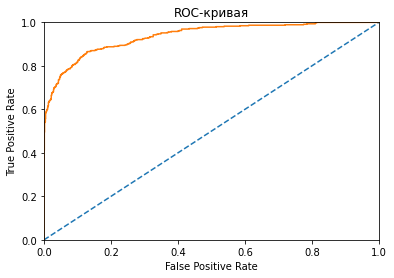

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, predicted)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

# Отчет по проекту.

В процессе работы над финальным проектом были проделаны следующие этапы: 
1.	Загрузка датасетов и первичный анализ (на входе мы получили 4 датасета);
2.	Объединение датасетов в один, заполнение пропусков после объединения, исправления формата некоторых столбцов;
3.	Расчет нового признака для последующего обучения (срок действия договора для каждого клиента);
4.	Создание целевого признака (существующий/ушедший клиент);
В результате получили датасет из 7043 строк(уникальных клиентов) и 22 столбцов с различными признаками.

5.	Исследовательский анализ данных:
	- Распределение признаков в датасете;
	- Распределение признаков между группой ушедших и существующих клиентов;
	- Анализ притока клиентов 
	- Анализ распределения ежемесячных платежей среди ушедших и существующих клиентов;
	- Анализ распределения срока действия договора среди ушедших и существующих клиентов;
	- Определение зависимости между различными признаками (анализ корреляции признаков);
	- Формулировка гипотез влияния признаков на отток клиентов на основе анализа данных. 

6.	Подготовка данных к обучению:
  - Удаление столбцов, мешающих обучению или которые могут быть утечкой данных;
  
 В результате для обучения оставила следующие признаки:
  
 Type              - тип оплаты: ежемесячно, раз в год или раз в два года
 PaperlessBilling  - выставляется ли счет в бумажном виде
 PaymentMethod     - способ оплаты
 MonthlyCharges    - сумма ежемесячного платежа
 TotalDays         - количество дней действия контракта с клиентом 
 SeniorCitizen     - является ли клиент старше 60 лет.
 Partner           - состоит ли клиент в браке 
 Dependents        - наличие иждевенцев 
 MultipleLines     - выделено несколько линий
 InternetService   - тип подключения интернета 
 OnlineSecurity    - подключена ли услуга онлайн безопасности
 OnlineBackup      - подключена ли услуга резервного копирования
 DeviceProtection  - антивирус
 TechSupport       - техническая поддержка  
 StreamingTV       - пользуется ли клиент стриминговым телевидением
 StreamingMovies   - использует ли клиент каталогом фильмов
 
 Целевой признак:
  no_client         - покинул ли клиент компанию  

  - Создание тестовой и обучающей выборки, а также целевого признака и фичей;
  - Кодирование категориальных переменных через OneHotEncoder;
  - Масштабирование количественных признаков;
   7. Обучение выбранных моделей на обучающей выборке и оценка качества этих моделей через кросс-валидацию:
  - модель RandomForestClassifier с параметрами ('max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 40) 
ROC_AUC на обучающей выборке  0.85886
  - модель CatBoostClassifier с параметрами ('depth': 2, 'l2_leaf_reg': 2, 'learning_rate': 0.3) 
ROC_AUC на обучающей выборке  0.93449
  - модель LGBMClassifier с параметрами ('learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 500)
ROC_AUC на обучающей выборке  0.91886
    
7.	Тестирование наилучшей модели:
Наилучший результат показала модель CatBoost, на тестовой выборке качество модели roc_auc 0.9370.

Все пункты плана были выполнены. В процессе работы возникли сложности с качеством модели и пришлось экспериментировать с дополнительными признаками (сначала рассматривала срок действия контракта в месяцах, но в когда перевела срок в дни, но качество модели поднялось с 0.86 до 0.93). 
Так же возникли сложности с оценкой признаков и выбором максимально значимых для модели и бизнеса.

8. Ключевые этапы решения задачи
Одним из важных и объемных этапов работу над проектом был анализ признаков, их распределения и взаимосвязи друг с другом. Это важный этап, чтобы понять как в дальнейшем работать с данными, какие использовать модели для обучения, с какими сложностями можем столкнуться.
Другим ключевым этапом был выбор моделей для обучения, а также подбор значений гиперпараметров.  выбранны
Одним из важнейших шагов могу назвать борьбу с дисбалансом и увеличение выборки. Также очень важно следить не только за ключевой метрикой, но и за такими метриками, как полнота и точность на каждой модели. Данные метрики в совокупности с матрицей ошибок способны указать на слабые стороны модели и понять, куда двигаться дальше. Третьим ключевым шагом могу отметить важность не только подбора значений гиперпараметров, но и определение какие из них оказывают наибольшее влияние на модель. Все вышеперечисленные шаги реализованы в моем проекте и помогли мне справиться с задачей.
